In [1]:
import hoomd
import hoomd.md
import numpy
import utils

What this code is going to help me do: "Set initial conditions for HOOMD using arbitrary python code via a snapshot. Use this to generate random initial conditions within a job script, provide customizable parameters for the initial conditions, or read from a custom file format".

In [13]:
#We first need to make a snapshat that is going to hold the particles
#To do this, we need:
    #N which is the number of particles
    #box which is the box the simulation happens in
    #particle_type which is the names of the particles in the simulation

#Here we initialize where the simulation is going to be run. Since we
#didn't put anything in as a parameter, HOOMD will select where the simulation
#is going to run - a GPU if it exists or a CPU.

hoomd.context.initialize("");

#Now we make an empty snapshot with the parameters we want - 10 particles
#with a box 2x2x4 and particles named A and B (okay these are a lie but still)
L = 20
a = hoomd.data.boxdim(L = L)
snapshot = hoomd.data.make_snapshot(N=4, box=a,
                                    particle_types=['A'],
                                    bond_types=['polymer'])

N = snapshot.particles.N
#I am told that the snapshot object contains numpy arrays with all the 
#particle properties

In [14]:
#Check to see what particles are in what position

#Can check more things by doing snapshot.particles.<parameter value found 
#on HOOMD documentation>

print(snapshot.particles.position)

#Particles are initialized with default properties

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [15]:
#This is a loop that will randomly generate numbers in the correct range so that particles can have random positions.
#You COULD, TECHNICALLY, use hoomd.deprecated.init.create_random() but NO, we are going to write our own code

for i in range(N):
    snapshot.particles.position[i] = utils.randNumGen(L)
print(snapshot.particles.position)

[[-8.021938   -0.23179755 -5.7075825 ]
 [ 8.152483    7.0744214   1.0907605 ]
 [-4.668156   -0.05723945  0.8200603 ]
 [ 3.3469756  -1.0618881  -2.3335748 ]]


In [16]:
#MUST UPDATE THIS IF YOU CHANGE THE NUMBER OF PARTICLES

snapshot.bonds.resize(3)
snapshot.bonds.group[:] = [[0,1], [1,2], [2,3]]

In [17]:
snapshot.replicate(4,4,4)
b = snapshot.particles.N

In [18]:
#Let's set velocity!

#(snapshot.particles.velocity[:] = numpy.random.normal(
#0.0, numpy.sqrt(0.8 / 1.0), [snapshot.particles.N, 3]);) - this is
#in DPD polymers as another velocity equation

numpy.random.seed(10) #not quite sure what the purpose of this is
my_velocity = numpy.random.random((b,3)) * 2 - 1
snapshot.particles.velocity[:] = my_velocity[:]
#print(snapshot.particles.velocity)

In [19]:
#Let's set mass!

snapshot.particles.mass[:] = 10
#print(snapshot.particles.mass)

In [20]:
hoomd.init.read_snapshot(snapshot);

notice(2): Group "all" created containing 256 particles


In [12]:
nl = hoomd.md.nlist.cell()

In [48]:
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)

In [49]:
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

In [50]:
hoomd.md.integrate.mode_standard(0.01)

In [51]:
all = hoomd.group.all()
hoomd.md.integrate.langevin(group = all, kT = 0, seed=42)

notice(2): integrate.langevin/bd is using specified gamma values


In [52]:
hoomd.analyze.log(filename = "densitycode-output.log",
                  quantities=['potential_energy', 'temperature'],
                  period = 100,
                  overwrite = True)

In [53]:
hoomd.dump.gsd("densityoutputs.gsd", period=500, group= all, overwrite = True)

In [54]:
hoomd.run(1e4)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1048320
notice(2): Particles with 1 exclusions             : 128
notice(2): Particles with 2 exclusions             : 128
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **


**ERROR**: Error allocating aligned memory


RuntimeError: Error allocating GPUArray.

In [18]:
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='densitycode-output.log', skip_header=True);

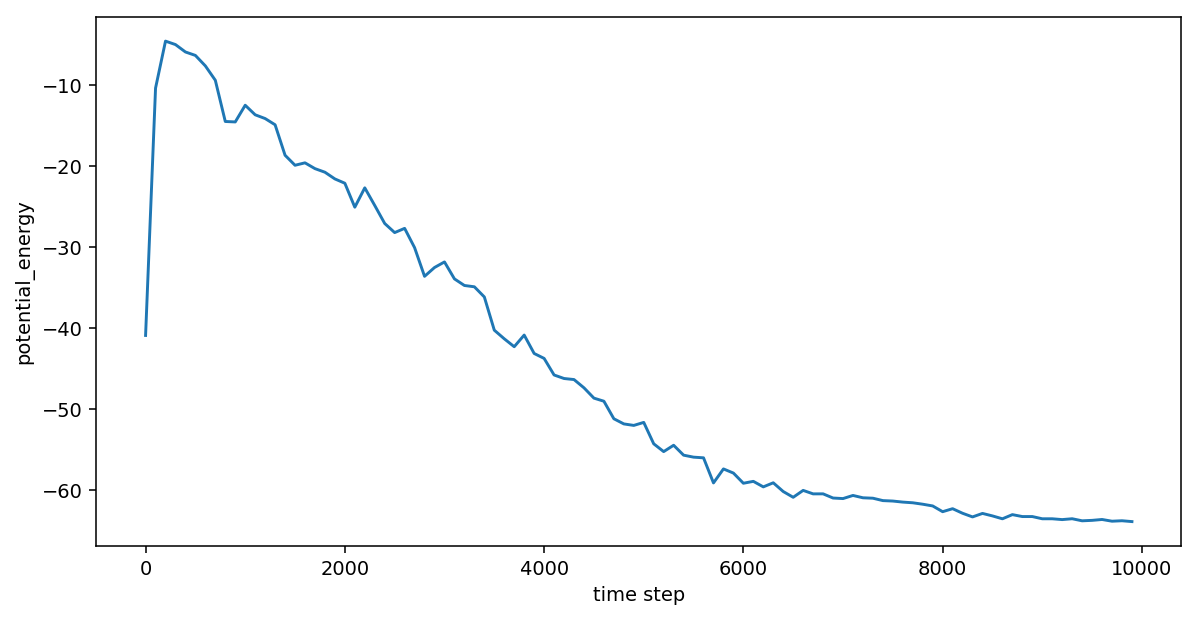

In [19]:
pyplot.figure(figsize=(10,5), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

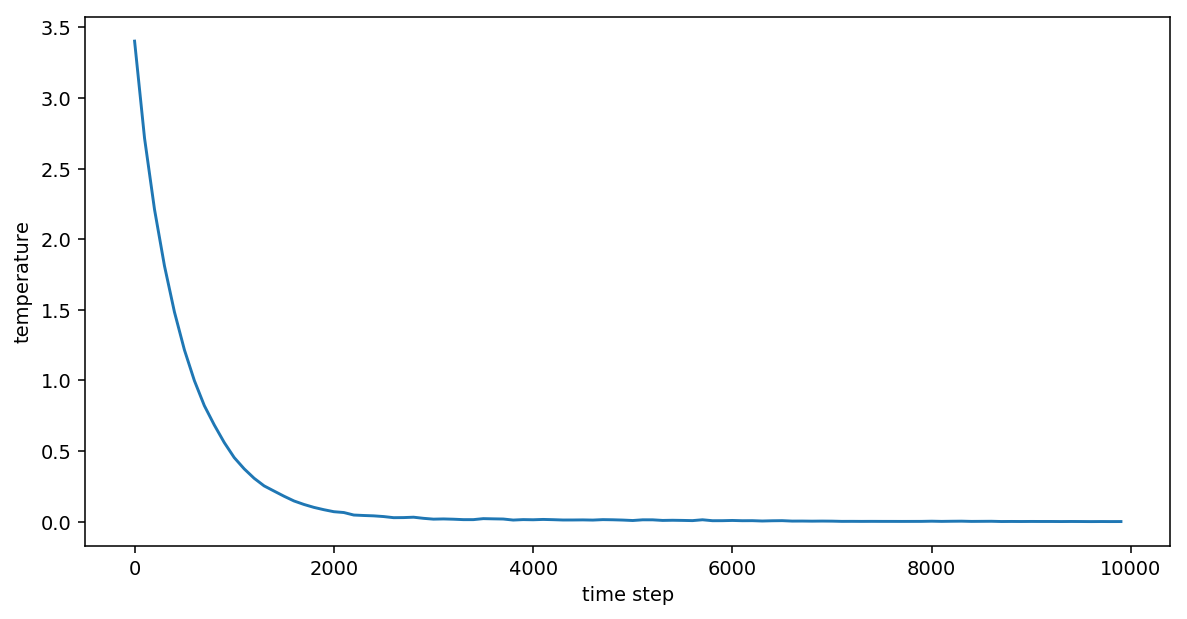

In [20]:
pyplot.figure(figsize=(10,5), dpi=140);
pyplot.plot(data[:,0], data[:,2]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');

In [21]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'densityoutputs.gsd')

ModuleNotFoundError: No module named 'ex_render'